## Numerov Method for Solving the Vibrational Schr&ouml;dinger Equation
[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/akanotoe/H2Numerov/HEAD)&nbsp;[![nbviewer](https://img.shields.io/badge/view%20in-nbviewer-orange)](https://nbviewer.jupyter.org/github/akanotoe/H2Numerov/blob/master/H2Numerov.ipynb)

The [Numerov method][numerov] is used to solve differential equations of the form

$$\frac{d^2 y}{dx^2} = - g(x) y(x) + s(x)$$

In the case of the 1D time-independent Schr&ouml;dinger equation, we have

$$\frac{d^2 \psi}{dx^2} = -\frac{2\mu(E-V(x))}{\hbar^2}\psi$$

We're going to work in the natural unit system of atomic and molecular physics, [atomic units][au]. The base units for this system are
* $\hbar$ - unit of action/angular momentum
* $m_e$ - unit of mass
* $e$ - unit of charge
* $4\pi\varepsilon_0$ - unit of permittivity
* $c\alpha$ - unit of speed
* $E_h = m_e c^2 \alpha^2$ - unit of energy
* $a_0 = \dfrac{\hbar}{m_e c\alpha}$ - unit of distance


Here, $\hbar$ is the reduced Planck constant, $m_e$ is the electron mass, $e$ is the fundamental charge, $c$ is the speed of light, and $\alpha=e^2/(4\pi\varepsilon_0\hbar c)$ is the fine structure constant. The derived constants for energy and distance are the Hartree energy ($E_h$) and the Bohr radius ($a_0$), respectively.

[numerov]: https://en.wikipedia.org/wiki/Numerov%27s_method "wiki:Numerov's method"
[au]: https://en.wikipedia.org/wiki/Hartree_atomic_units "wiki:Atomic Units"

To simplify the Schr&ouml;dinger equation for computation, we will nondimensionalize it using the above system of units. The equation has units of inverse area ($L^{-2}$), so we will multiply both sides by $a_0^2 = \hbar^2/(m_e c\alpha)^2$,

$$\frac{d^2 \psi}{d(x/a_0)^2} = -\frac{2\mu(E-V(x/a_0))}{m_e^2 c^2\alpha^2}\psi.$$

Defining $\xi=x/a_0$, we obtain

$$\frac{d^2 \psi}{d\xi^2} = -\frac{2(\mu/m_e)(E-V(\xi))}{E_h}\psi.$$

Since the independent variable is now dimensionless, so is $\psi$, and the equation as a whole is now dimensionless. The potential energy curves we will be using in these computations are in atomic units, so starting with an equation that works in these units will be beneficial.

Comparing our dimensionless Schr&ouml;dinger equation with the first differential equation, we can identify
* $x \to \xi$
* $y \to \psi$
* $g(x) \to 2(\mu/m_e)(E-V(\xi))/E_h$


Computationally, the Numerov method relates these quantities to each other in the following way:

$$
\begin{align}
\psi_{n+1} \left(1 + \frac{(\Delta \xi)^2}{12} \frac{2\, (\mu/m_e)(E-V_{n+1})}{E_h} \right) 
&= 2 \psi_n \left(1 - \frac{5 (\Delta \xi)^2}{12} \frac{2\, (\mu/m_e)(E-V_{n})}{E_h} \right)\\ 
&\!\quad - \psi_{n-1} \left(1 + \frac{(\Delta \xi)^2}{12} \frac{2\, (\mu/m_e)(E-V_{n-1})}{E_h} \right) \\
&\!\quad + \mathcal{O} \left((\Delta \xi)^6 \right).
\end{align}
$$

We can also write this in matrix notation as (Pillai, Goglio, and Walker, [*Am. J. Phys.*](http://dx.doi.org/10.1119/1.4748813) **80**, 1017 (2012), [PDF](https://pages.physics.wisc.edu/~tgwalker/106.Numerov.pdf))

$$A \, \psi = -2 (\mu/m_e)\, B\, \frac{(E-V)}{E_h}\psi$$

where 

$$A = \frac{1}{(\Delta \xi)^2}
\begin{pmatrix}
-2 & 1 & 0 & 0 & \cdots \\
1 & -2 & 1 & 0 &\cdots \\
0 & 1 & -2 & 1 & \cdots \\
0 & 0 &  1 & -2 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix}
, \quad
B = \frac{1}{12}
\begin{pmatrix}
10 & 1 & 0 & 0 & \cdots \\
1 & 10 & 1 & 0 &\cdots \\
0 & 1 & 10 & 1 & \cdots \\
0 & 0 &  1 & 10 & \cdots \\
\vdots & \vdots & \vdots & \vdots & \ddots
\end{pmatrix},
$$

$\psi$ is treated as a column vector, and $V$ is a diagonal matrix. We can rearrange this to get an eigenvalue equation,

$$\left(-\frac{1}{2(\mu/m_e)} B^{-1}A + \frac{V}{E_h}\right)\psi = \frac{E}{E_h}\psi,$$

where we can see that

$$H = -\frac{1}{2(\mu/m_e)} B^{-1}A + \frac{V}{E_h}$$

is the Hamiltonian in the Numerov representation. Finding the eigenvalues of this matrix will yield the energies of the system.

Here I'm going to write code to run the Numerov method on arbitrary potential functions of the H<sub>2</sub> molecule. Our first step is to import the necessary packages we will need.

In [1]:
import numpy as np
from scipy.interpolate import interp1d
from scipy import integrate
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# This cell makes the text in plots the same as LaTeX
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size='14')

Next, we need to import the data that defines our potential energy curve. I'm going to use the X <sup>1</sup>&Sigma;<sub>g</sub><sup>+</sup> state of H<sub>2</sub>. This next cell imports the data, interpolates it, and plots the data with its interpolation.

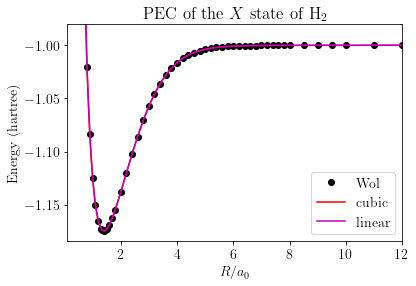

In [3]:
# Import PEC data
datin = open('INPUT','r')
pecfile = datin.readline()
pecfile = pecfile[:-1]
outname = pecfile
pecname = datin.readline()
pecname = pecname[:-1]
ndis = datin.readline()
ndis = float(ndis)
adiab = datin.readline()
adiab = float(adiab)
dissoc = (1. + ndis**(-2))/2 + adiab
# dissoc = 0.5 - 2.66745828957582E-4 # Uncomment for H2+ ground state
# dissoc = 0.52744951 # Uncomment for ion-pair state
datin.close()
R, U = np.genfromtxt(pecfile + '.dat').transpose()

# Interpolate PEC
RU = R**3*U
R = np.insert(R, 0, 0.)
RU = np.insert(RU, 0, 0.)
RU = RU[:10]
Rru = R[:10]
RUint = interp1d(Rru, RU, kind='cubic')
# RUint = splrep(Rru, RU)
intspace = 0.1
Rmin = R[1]
intmin = 0.5
npts = (Rmin-intmin)/intspace + 1
if intmin < Rmin:
    Rint = np.linspace(intmin, Rmin, num=npts, endpoint=True)
else:
    Rint=[]
RU = RUint(Rint)
RU = RU[:-1]
Rint = Rint[:-1]
Uinner = RU/Rint/Rint/Rint
U = np.insert(U, 0, Uinner)
R = R[1:]
R = np.insert(R, 0, Rint)

# Table of R with mesh size of dR a0
Rmin = R[0]
Rmax = R[len(R)-1]
npts = 2048
Rint = np.linspace(Rmin, Rmax, num=npts, endpoint=True)
dR = Rint[1]-Rint[0]

# Interpolate U over table of R values, then use that to get U(Rint)
Uint = interp1d(R, U, kind='cubic')
Uintlin = interp1d(R, U, kind='slinear')

# Min and max energies for plots
Uplmin = min(U-.01)
Uplmax = -dissoc +.02

# Plot of PEC data vs. interpolation
plt.figure()
plt.plot(R, U, 'ko', Rint, Uint(Rint), 'r-', Rint, Uintlin(Rint), 'm-')
plt.legend(['Wol', 'cubic', 'linear'], loc='best')
plt.xlim([0.1,Rmax])
plt.ylim([Uplmin,Uplmax])
plt.xlabel('$R/a_0$')
plt.ylabel('Energy (hartree)')
plt.title('PEC of the $' + pecname + '$ state of H$_2$');
# plt.savefig(outname + 'plot.svg')

Now we construct the $A$, $B$, and $V$ matrices.

In [4]:
# Construct A and B matrices
# Rlen = int(len(Rint)*0.66) # Uncomment if spline makes oscillations at large R
# Rint = Rint[:Rlen]
A = dR**(-2)*(np.diag(np.ones(len(Rint)-1), -1) - 2.*np.diag(np.ones(len(Rint)), 0) + np.diag(np.ones(len(Rint)-1), 1))
B = 1./12*(np.diag(np.ones(len(Rint)-1), -1) + 10.*np.diag(np.ones(len(Rint)), 0) + np.diag(np.ones(len(Rint)-1), 1))

# mass of proton for Schrodinger Eqn in me
mp = 1836.152674

# Construct V matrix
J = 0
V = np.diag(Uint(Rint) + J*(J+1)/mp/Rint/Rint + dissoc)

Check that interpolation was cut off before oscillations.

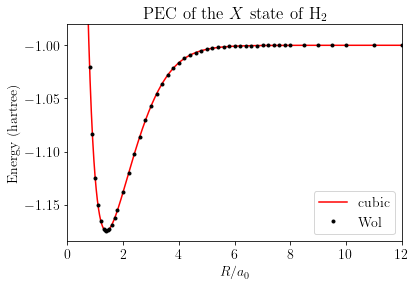

In [5]:
# Plot of PEC data vs. interpolation
plt.figure()
plt.plot(Rint, Uint(Rint), 'r-', R, U, 'k.')
plt.legend(['cubic', 'Wol'], loc='best')
plt.xlim([0,Rmax])
plt.ylim([Uplmin,Uplmax])
# plt.xscale('log')
plt.xlabel('$R/a_0$')
plt.ylabel('Energy (hartree)')
plt.title('PEC of the $' + pecname + '$ state of H$_2$');
# plt.savefig(outname + 'plot.svg')

This next part is quite computationally intensive. Here we invert $B$ and get the eigenvalues $E$ and eigenvectors $\psi$ of $H$.

In [6]:
# Take inverse of B
Binv = np.linalg.inv(B)

# Get eigenvalues and eigenvectors (psi) of Hamiltonian.
en, psi = np.linalg.eigh(-1/mp * np.dot(Binv, A) + V)

# Normalize the wavefunctions
psi = psi/dR**0.5

# Old normalization:
# for v in range(0,len(en)-1):
#     if en[v] < 0:
#         psiint = interp1d(Rint, psi[:,v]*psi[:,v], kind='cubic')
#         norm = integrate.simps(psi[:,v]**2, Rint)
#         psi[:,v] = psi[:,v]/norm**0.5

# Produce rotational distances. See below for definition.
r2inv=[]
for v in range(0,len(en)-1):
    if en[v] < 0:
        r2inv.append(integrate.simps(psi[:,v]**2 / Rint**2, Rint))

Now that we have our results, we export the eigenvalues and wavefunctions as data files.

In [7]:
# Export wavefunctions and energies as files
enfile = open(outname + 'j' + str(J) + 'energies.dat', 'w')
for v in range(0,len(en)-1):
    if en[v] < 0:
        enfile.write(str(en[v] - dissoc) + '\n')
        if v<10:
            psifile = open(outname + 'wfJ' + str(J) + 'v00' + str(v) + '.dat', 'w')
# Uncomment for states with over 100 wave functions, change above line to
# have 'wfv00' after outname +.
        elif (v>=10 and v<100):
           psifile = open(outname + 'wfJ' + str(J) + 'v0' + str(v) + '.dat', 'w')
        else:
            psifile = open(outname + 'wfJ' + str(J) + '.dat', 'w')
        for j in range(len(Rint)):
            psifile.write(str(Rint[j])+ '\t' + str(psi[j][v]) + '\n')
        psifile.close()
enfile.close()

# Export Term energies as a file.
Eh = 219474.63137
Xv0= 255475.613105
Bv = []
for v in range(len(en)):
    if en[v] < 0:
        Bv.append(Eh/mp*r2inv[v])
term = (en-dissoc)*Eh + Xv0
termfile = open(outname + 'j' + str(J) + 'termen.dat', 'w')
termfile.write('v' + '\t' + 'Term energy' + '\t' + 'Bv (cm^-1)' + '\n')
for v in range(len(en)):
    if en[v] < 0:
        termfile.write(str(v) + '\t' + str(term[v]) + '\t' + str(Bv[v]) + '\n')
termfile.close()

While debugging my code I plotted some vibrational wavefunctions with their potential energy curves.

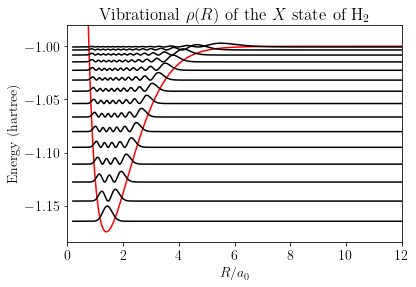

In [8]:
# Rmax=35
plt.figure()
# plt.xscale('log')
# plt.xlim([0.1,Rmax])
plt.xlim([0,Rmax])
plt.ylim([Uplmin,Uplmax])
plt.plot(Rint, Uint(Rint), 'r-')
for v in range(len(en)):
    if en[v] < 0:
        plt.plot(Rint, .006*psi[:,v]*psi[:,v] + en[v]-dissoc, 'k-')
# plt.legend(['$v$', outname[:1] + ' state'], loc='best')
plt.xlabel('$R/a_0$')
plt.ylabel('Energy (hartree)')
plt.title('Vibrational $\\rho(R)$ of the $' + pecname + '$ state of H$_2$');
# plt.savefig(outname + 'vibplot.svg')

This next plot gives a picture of the bond length of the molecule for each vibration. If the molecule is assumed to be a [rigid rotor][rotor], i.e. a barbell with two masses rotating about their center of mass, we can calculate the average internuclear spacing based on what the rotational structure looks like. The rotational energy of a quantum mechanical rigid rotor is given by
$$
\begin{aligned}
E_J &= \hbar^2 \left<\dfrac{1}{2I}\right> J(J+1) 
= \dfrac{E_h}{2 (\mu/m_e)} \left< \dfrac{1}{(R/a_0)^2} \right> J(J+1)\\
&= B_v \, J(J+1),
\end{aligned}
$$
where $I=\mu R^2$ is the moment of inertia of the molecule, and the second form of the expression is given in atomic units. The coefficient of $J(J+1)$ &ndash; commonly labeled $B_v$ &ndash; is known as the rotational constant. Note that we have to take the expectation value of $I$ (or rather, its inverse) because the vibrational eigenstates are not also eigenstates of $R$ or powers of $R$. The "Rotational $R$" plotted below is essentially this expectation value; more specifically, $R_{\rm rot} = \langle R^{-2}\rangle^{-1/2}$.

[rotor]:https://en.wikipedia.org/wiki/Rigid_rotor "Wikipedia: Rigid Rotor"

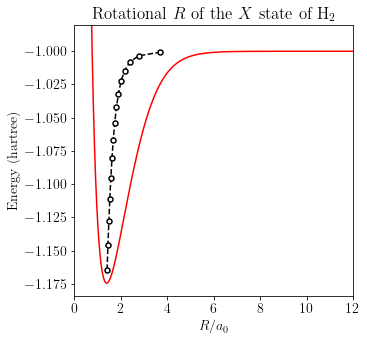

In [9]:
enplot = []
rrot = []
plt.figure(figsize=(5,5))
for v in range(len(en)):
    if en[v] < 0:
        enplot.append(en[v] - dissoc)
        rrot.append(np.sqrt(1./r2inv[v]))
plt.plot(rrot, enplot, '--ko', markerfacecolor='#ffffff', markersize=5, markeredgewidth=1.5)
plt.plot(Rint, Uint(Rint), 'r-')
# plt.legend(['$v$', outname[:1] + ' state'], loc='best')
plt.xlim([0,Rmax])
plt.ylim([Uplmin,Uplmax])
# plt.xscale('log')
plt.xlabel('$R/a_0$')
plt.ylabel('Energy (hartree)')
# plt.gca().set_aspect(Rmax/(Uplmax-Uplmin), adjustable='box')
plt.title('Rotational $R$ of the $' + pecname + '$ state of H$_2$');
# plt.savefig(outname + 'rotplot.svg')

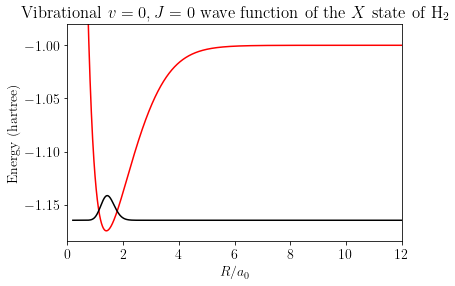

In [10]:
# Plots of individual wave functions
v = 0
plt.figure()
plt.plot(Rint, Uint(Rint), 'r-')
# plt.legend(['$v$', outname[:1] + ' state'], loc='best')
plt.plot(Rint, -0.015*psi[:,v] + en[v]-dissoc, 'k')
plt.xlim([0,Rmax])
plt.ylim([Uplmin,Uplmax])
# plt.xscale('log')
plt.xlabel('$R/a_0$')
plt.ylabel('Energy (hartree)')
plt.title('Vibrational $v='+ str(v) + ', J=' + str(J) +'$ wave function of the $' + pecname + '$ state of H$_2$');
# plt.savefig(outname + 'vib{:02d}plot.svg'.format(v))